# BCI Training & Fine-Tuning Pipeline Test - Google Colab Version

Este notebook testa o pipeline completo no Google Colab:
1. **Setup**: Instalar dependências e clonar repositório
2. **Treinamento Principal**: Subjects 1-79 do dataset PhysioNet
3. **Fine-Tuning**: Dados específicos da pasta Davi
4. **Validação**: Métricas e comparação de performance

## ⚠️ IMPORTANTE: Este notebook foi adaptado para Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Setup Inicial no Google Colab

Vamos instalar as dependências e configurar o ambiente adequadamente.

In [2]:
# === INSTALAÇÃO DE DEPENDÊNCIAS ===
print("🔧 Instalando dependências necessárias...")

# Instalar braindecode e dependências científicas
!pip install braindecode mne torch torchvision torchaudio
!pip install scikit-learn pandas numpy matplotlib seaborn
!pip install scipy jupyter

print("✅ Dependências instaladas!")

# Verificar se está no Colab
try:
    import google.colab
    IN_COLAB = True
    print("📱 Executando no Google Colab")
except ImportError:
    IN_COLAB = False
    print("💻 Executando localmente")

🔧 Instalando dependências necessárias...
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 15.5 MB/s eta 0:00:00

   ---------------- ----------------------- 2/5 [ipywidgets]
   ---------------- ----------------------- 2/5 [ipywidgets]
   ---------------- ----------------------- 2/5 [ipywidgets]
   ---------------- ----------------------- 2/5 [ipywidgets]
   ------------------------ --------------- 3/5 [jupyter-console]
   ---------------------------------------- 5/5 [jupyter]

✅ Dependências instaladas!
💻 Executando localmente


In [3]:
# === CLONE DO REPOSITÓRIO (OPCIONAL) ===
import os
from pathlib import Path

if IN_COLAB:
    print("🔄 Configurando para Google Colab...")

    # Se você quiser clonar seu repositório:
    # !git clone https://github.com/seu-usuario/projetoBCI.git
    # os.chdir('/content/projetoBCI')

    # Por enquanto, vamos trabalhar no diretório padrão do Colab
    project_root = Path('/content')

    # Criar estrutura de diretórios
    (Path("eeg_data")).mkdir(exist_ok=True)
    (project_root / "models").mkdir(exist_ok=True)
    (project_root / "results").mkdir(exist_ok=True)

else:
    # Executando localmente
    project_root = Path(os.getcwd()).parent

print(f"📂 Diretório de trabalho: {project_root}")
print(f"📁 Estrutura criada!")

📂 Diretório de trabalho: c:\Users\Chari\OneDrive\Documentos
📁 Estrutura criada!


## 2. Implementação das Classes Base (Inline)

Já que não temos o repositório clonado, vamos implementar as classes principais inline.

In [4]:
# === IMPLEMENTAÇÃO INLINE DAS CLASSES BASE ===
import torch
import torch.nn as nn
import numpy as np
from scipy import signal
from typing import Optional, List, Tuple, Dict, Union
import pandas as pd
from datetime import datetime
import json
import logging
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configurar logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("✅ Imports básicos carregados!")

✅ Imports básicos carregados!


In [5]:
# === UNIVERSAL EEG NORMALIZER ===
class UniversalEEGNormalizer:
    """Normalizador universal para dados EEG"""

    def __init__(self, method: str = 'zscore', mode: str = 'training'):
        self.method = method
        self.mode = mode
        self.global_stats = {}
        self.is_fitted = False

    def _ensure_3d(self, data: np.ndarray) -> np.ndarray:
        """Garantir que dados estejam em 3D (n_samples, n_channels, n_timepoints)"""
        if len(data.shape) == 2:
            n_samples, n_features = data.shape
            if n_features % 16 == 0:  # Assumir 16 canais
                n_channels = 16
                n_timepoints = n_features // n_channels
                data = data.reshape(n_samples, n_channels, n_timepoints)
            else:
                data = data[:, np.newaxis, :]
        elif len(data.shape) == 1:
            data = data[np.newaxis, np.newaxis, :]
        return data

    def fit(self, data: np.ndarray):
        """Ajustar normalizador aos dados"""
        data_3d = self._ensure_3d(data)

        if self.method == 'zscore':
            self.global_stats['mean'] = np.mean(data_3d, axis=(0, 2), keepdims=True)
            self.global_stats['std'] = np.std(data_3d, axis=(0, 2), keepdims=True)
            self.global_stats['std'] = np.where(self.global_stats['std'] == 0, 1.0, self.global_stats['std'])

        self.is_fitted = True
        return self

    def transform(self, data: np.ndarray) -> np.ndarray:
        """Transformar dados"""
        if not self.is_fitted:
            raise ValueError("Normalizador deve ser ajustado antes da transformação")

        original_shape = data.shape
        data_3d = self._ensure_3d(data)

        if self.method == 'zscore':
            normalized = (data_3d - self.global_stats['mean']) / self.global_stats['std']

        # Restaurar forma original
        if len(original_shape) == 2:
            return normalized.reshape(original_shape[0], -1)
        elif len(original_shape) == 1:
            return normalized.flatten()
        return normalized

    def fit_transform(self, data: np.ndarray) -> np.ndarray:
        """Ajustar e transformar em um passo"""
        return self.fit(data).transform(data)

print("✅ UniversalEEGNormalizer implementado!")

✅ UniversalEEGNormalizer implementado!


# Normalização Melhorada para EEG

Implementação de um normalizador mais robusto com:
- Múltiplas estratégias de normalização
- Validação de qualidade
- Tratamento de outliers
- Normalização por canal ou por trial

In [6]:
# === IMPROVED EEG NORMALIZER ===
import numpy as np
from typing import Dict, Optional, Tuple
from sklearn.preprocessing import RobustScaler


class ImprovedEEGNormalizer:
    """Normalizador EEG avançado com múltiplas estratégias e validação"""
    
    def __init__(self, method: str = 'robust_zscore', scope: str = 'channel',
                 outlier_threshold: float = 3.0):
        """
        Args:
            method: 'robust_zscore', 'minmax', ou 'raw_zscore'
            scope: 'channel', 'trial', ou 'global'
            outlier_threshold: número de desvios para considerar outlier
        """
        self.method = method
        self.scope = scope
        self.outlier_threshold = outlier_threshold
        self.stats: Dict = {}
        self.is_fitted = False
        
    def _handle_outliers(self, X: np.ndarray) -> np.ndarray:
        """Detecta e trata outliers usando IQR ou desvio padrão"""
        if self.method == 'robust_zscore':
            Q1 = np.percentile(X, 25, axis=(0, 2), keepdims=True)
            Q3 = np.percentile(X, 75, axis=(0, 2), keepdims=True)
            IQR = Q3 - Q1
            lower = Q1 - self.outlier_threshold * IQR
            upper = Q3 + self.outlier_threshold * IQR
        else:
            mean = np.mean(X, axis=(0, 2), keepdims=True)
            std = np.std(X, axis=(0, 2), keepdims=True)
            lower = mean - self.outlier_threshold * std
            upper = mean + self.outlier_threshold * std
            
        # Clip valores extremos
        return np.clip(X, lower, upper)
    
    def fit(self, X: np.ndarray) -> 'ImprovedEEGNormalizer':
        """Ajusta o normalizador aos dados
        
        Args:
            X: Array (trials, channels, time) ou (trials, features)
        """
        # Garantir formato 3D
        if len(X.shape) == 2:
            if X.shape[1] % 16 == 0:  # Assumir 16 canais
                n_channels = 16
                X = X.reshape(X.shape[0], n_channels, -1)
            else:
                X = X[:, np.newaxis, :]
                
        # Tratar outliers
        X = self._handle_outliers(X)
        
        if self.scope == 'channel':
            if self.method == 'robust_zscore':
                self.stats['median'] = np.median(X, axis=(0, 2), keepdims=True)
                q75, q25 = np.percentile(X, [75, 25], axis=(0, 2))
                self.stats['iqr'] = (q75 - q25)[None, :, None] + 1e-8
                
            elif self.method == 'minmax':
                self.stats['min'] = X.min(axis=(0, 2), keepdims=True)
                self.stats['max'] = X.max(axis=(0, 2), keepdims=True)
                
            else:  # raw_zscore
                self.stats['mean'] = np.mean(X, axis=(0, 2), keepdims=True)
                self.stats['std'] = np.std(X, axis=(0, 2), keepdims=True) + 1e-8
                
        elif self.scope == 'trial':
            if self.method == 'robust_zscore':
                self.stats['median'] = np.median(X, axis=2, keepdims=True)
                q75, q25 = np.percentile(X, [75, 25], axis=2)
                self.stats['iqr'] = (q75 - q25)[:, :, None] + 1e-8
                
            elif self.method == 'minmax':
                self.stats['min'] = X.min(axis=2, keepdims=True)
                self.stats['max'] = X.max(axis=2, keepdims=True)
                
            else:  # raw_zscore
                self.stats['mean'] = np.mean(X, axis=2, keepdims=True)
                self.stats['std'] = np.std(X, axis=2, keepdims=True) + 1e-8
        
        self.is_fitted = True
        return self
    
    def transform(self, X: np.ndarray) -> np.ndarray:
        """Transforma os dados usando as estatísticas calculadas"""
        if not self.is_fitted:
            raise ValueError("Normalize.fit() deve ser chamado antes de transform()")
            
        # Garantir formato 3D
        original_shape = X.shape
        if len(X.shape) == 2:
            if X.shape[1] % 16 == 0:
                n_channels = 16
                X = X.reshape(X.shape[0], n_channels, -1)
            else:
                X = X[:, np.newaxis, :]
                
        # Transformação
        if self.method == 'robust_zscore':
            X_norm = (X - self.stats['median']) / self.stats['iqr']
        elif self.method == 'minmax':
            X_norm = (X - self.stats['min']) / (self.stats['max'] - self.stats['min'] + 1e-8)
        else:  # raw_zscore
            X_norm = (X - self.stats['mean']) / self.stats['std']
            
        # Restaurar forma original se necessário
        if len(original_shape) == 2:
            X_norm = X_norm.reshape(original_shape)
            
        return X_norm
    
    def fit_transform(self, X: np.ndarray) -> np.ndarray:
        """Ajusta aos dados e transforma em um único passo"""
        return self.fit(X).transform(X)
    
    def get_stats(self) -> Dict:
        """Retorna estatísticas de normalização"""
        return self.stats.copy()


def validate_normalization(X: np.ndarray, normalized_X: np.ndarray) -> Tuple[bool, Dict]:
    """Valida a qualidade da normalização
    
    Args:
        X: Dados originais
        normalized_X: Dados normalizados
        
    Returns:
        (is_valid, stats): Booleano indicando se passou nos checks e estatísticas
    """
    stats = {}
    
    # 1. Verificar média e desvio
    stats['mean'] = float(np.mean(normalized_X))
    stats['std'] = float(np.std(normalized_X))
    
    # 2. Calcular percentis
    stats['percentiles'] = {
        '1%': float(np.percentile(normalized_X, 1)),
        '99%': float(np.percentile(normalized_X, 99))
    }
    
    # 3. Verificar preservação de ordem relativa
    original_order = np.argsort(np.mean(X, axis=(1,2)))
    normalized_order = np.argsort(np.mean(normalized_X, axis=(1,2)))
    stats['order_correlation'] = float(np.corrcoef(original_order, normalized_order)[0,1])
    
    # 4. Verificar outliers
    z_scores = np.abs((normalized_X - np.mean(normalized_X)) / np.std(normalized_X))
    stats['outliers_ratio'] = float(np.mean(z_scores > 3))
    
    # Critérios de validação
    is_valid = (
        abs(stats['mean']) < 0.1 and           # Média próxima de zero
        abs(stats['std'] - 1) < 0.5 and        # Desvio próximo de 1
        stats['order_correlation'] > 0.7 and    # Preserva ordem relativa
        stats['outliers_ratio'] < 0.01         # Menos de 1% outliers
    )
    
    return is_valid, stats

print("✅ Normalizador melhorado implementado!")

✅ Normalizador melhorado implementado!


In [7]:
# === BCI DATASET CLASS ===
class BCIDataset(Dataset):
    """Dataset PyTorch para dados EEG"""

    def __init__(self, windows: np.ndarray, labels: np.ndarray, transform=None, augment: bool = False):
        self.windows = torch.from_numpy(windows).float()
        self.labels = torch.from_numpy(labels).long()
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window = self.windows[idx]
        label = self.labels[idx]

        if self.augment:
            # Adicionar ruído leve
            if torch.rand(1) < 0.3:
                noise = torch.randn_like(window) * 0.01
                window = window + noise

        if self.transform:
            window = self.transform(window)

        return window, label

print("✅ BCIDataset implementado!")

✅ BCIDataset implementado!


In [8]:
# === EEG INCEPTION ERP MODEL ===
try:
    from braindecode.models import EEGInceptionERP
    print("✅ Braindecode EEGInceptionERP importado com sucesso!")
    BRAINDECODE_AVAILABLE = True
except ImportError as e:
    print(f"❌ Erro ao importar braindecode: {e}")
    print("🔧 Vamos implementar um modelo CNN simples como fallback")
    BRAINDECODE_AVAILABLE = False

class EEGInceptionERPModel(nn.Module):
    """Wrapper para EEGInceptionERP com fallback para CNN simples"""

    def __init__(self, n_chans: int, n_outputs: int, n_times: int, sfreq: float = 125.0, **kwargs):
        super().__init__()
        self.n_chans = n_chans
        self.n_outputs = n_outputs
        self.n_times = n_times
        self.sfreq = sfreq
        self.is_trained = False

        if BRAINDECODE_AVAILABLE:
            try:
                self.model = EEGInceptionERP(
                    n_chans=n_chans,
                    n_outputs=n_outputs,
                    n_times=n_times,
                    sfreq=sfreq
                )
                self.model_type = "EEGInceptionERP"
                print(f"✅ Usando EEGInceptionERP: {n_chans} canais, {n_times} pontos temporais")
            except Exception as e:
                print(f"⚠️ Erro ao criar EEGInceptionERP: {e}")
                self.model = self._create_fallback_cnn(n_chans, n_outputs, n_times)
                self.model_type = "FallbackCNN"
        else:
            self.model = self._create_fallback_cnn(n_chans, n_outputs, n_times)
            self.model_type = "FallbackCNN"

    def _create_fallback_cnn(self, n_chans: int, n_outputs: int, n_times: int):
        """Criar CNN simples como fallback"""
        print(f"🔧 Criando CNN fallback: {n_chans} canais, {n_times} pontos temporais")
        return nn.Sequential(
            # Convolução temporal
            nn.Conv1d(n_chans, 32, kernel_size=25, padding=12),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.25),

            # Redução de dimensionalidade
            nn.Conv1d(32, 64, kernel_size=15, padding=7),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Dropout(0.25),

            # Convolução final
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),

            # Classificador
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, n_outputs)
        )

    def forward(self, x):
        if self.model_type == "EEGInceptionERP":
            return self.model(x)
        else:
            # Para o CNN fallback, precisamos transpor de (batch, channels, time) para (batch, channels, time)
            return self.model(x)

    def save(self, filepath: str):
        """Salvar modelo"""
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        save_dict = {
            'model_state_dict': self.model.state_dict(),
            'model_type': self.model_type,
            'n_chans': self.n_chans,
            'n_outputs': self.n_outputs,
            'n_times': self.n_times,
            'sfreq': self.sfreq,
            'is_trained': self.is_trained
        }
        torch.save(save_dict, filepath)
        print(f"✅ Modelo salvo: {filepath}")

    def load(self, filepath: str):
        """Carregar modelo"""
        checkpoint = torch.load(filepath, map_location='cpu')
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.is_trained = checkpoint.get('is_trained', True)
        print(f"✅ Modelo carregado: {filepath}")

print(f"✅ EEGInceptionERPModel implementado! Tipo: {'Braindecode' if BRAINDECODE_AVAILABLE else 'Fallback CNN'}")

✅ Braindecode EEGInceptionERP importado com sucesso!
✅ EEGInceptionERPModel implementado! Tipo: Braindecode


## 3. Configuração dos Caminhos e Parâmetros

In [16]:
from pathlib import Path

# --- Raiz do seu trabalho no Drive ------------------------------------------------
PROJECT_ROOT = Path("eeg_data")

# --- Dados ------------------------------------------------------------------------
EEG_DATA_PATH  = PROJECT_ROOT / "MNE-eegbci-data/files/eegmmidb/1.0.0"
DAVI_DATA_PATH = EEG_DATA_PATH / "Davi"

# --- Saída de modelos e resultados ------------------------------------------------
MODELS_PATH  = PROJECT_ROOT / "models"     # <-- ajuste se quiser outro local
RESULTS_PATH = PROJECT_ROOT / "results"

# Cria as pastas se ainda não existirem (evita erros de salvamento depois)
MODELS_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

# --- Parâmetros de treinamento ---------------------------------------------------
TRAINING_PARAMS = {
    # Configurações de dados
    'exclude_subjects': ['Davi'],  # treina com todos exceto Davi
    'data_base_path': str(EEG_DATA_PATH),
    'model_save_path': str(MODELS_PATH),        # ← CORRIGIDO
    'results_save_path': str(RESULTS_PATH),     # ← CORRIGIDO
    
    # Configurações de treinamento
    'num_k_folds': 10,            # Mantido em 10 como estava funcionando
    'num_epochs_per_fold': 30,    # Mantido em 30
    'batch_size': 10,             # Mantido como estava
    'early_stopping_patience': 8, # Mantido como estava
    'learning_rate': 1e-3,        # Taxa de aprendizado
    'test_split_ratio': 0.2,      # Proporção do conjunto de teste
    
    # Identificação do modelo
    'model_name': 'eeg_inception_openbci_cv10',  # Nome do modelo
    
    # Configurações de normalização
    'normalization': {
        'method': 'robust_zscore',
        'scope': 'channel',
        'outlier_threshold': 3.0
    },
    
    # Configurações de treino avançadas
    'use_class_weights': True,    # Adiciona pesos para classes desbalanceadas
    'use_scheduler': True,        # Usa learning rate scheduler
    'scheduler_params': {
        'factor': 0.5,            # Reduz LR pela metade
        'patience': 5,            # Espera 5 épocas antes de reduzir
        'min_lr': 1e-6           # LR mínimo
    },
    
    # Configurações de salvamento
    'save_model': True,           # ← NOVO: flag para salvar modelo
    'save_results': True,         # ← NOVO: flag para salvar resultados
    'save_history': True          # ← NOVO: flag para salvar histórico detalhado
}

print("✅ Configurações corrigidas:")
print(f"📂 Diretório de dados: {EEG_DATA_PATH}")
print(f"🏗️ Modelos: {MODELS_PATH}")
print(f"📊 Resultados: {RESULTS_PATH}")
print("\n📝 Parâmetros principais:")
for key, value in TRAINING_PARAMS.items():
    if isinstance(value, dict):
        print(f"  {key}:")
        for k, v in value.items():
            print(f"    - {k}: {v}")
    else:
        print(f"  - {key}: {value}")

print(f"\n🔧 CORREÇÃO APLICADA: Adicionadas chaves 'model_save_path' e 'results_save_path'")

✅ Configurações corrigidas:
📂 Diretório de dados: eeg_data\MNE-eegbci-data\files\eegmmidb\1.0.0
🏗️ Modelos: eeg_data\models
📊 Resultados: eeg_data\results

📝 Parâmetros principais:
  - exclude_subjects: ['Davi']
  - data_base_path: eeg_data\MNE-eegbci-data\files\eegmmidb\1.0.0
  - model_save_path: eeg_data\models
  - results_save_path: eeg_data\results
  - num_k_folds: 10
  - num_epochs_per_fold: 30
  - batch_size: 10
  - early_stopping_patience: 8
  - learning_rate: 0.001
  - test_split_ratio: 0.2
  - model_name: eeg_inception_openbci_cv10
  normalization:
    - method: robust_zscore
    - scope: channel
    - outlier_threshold: 3.0
  - use_class_weights: True
  - use_scheduler: True
  scheduler_params:
    - factor: 0.5
    - patience: 5
    - min_lr: 1e-06
  - save_model: True
  - save_results: True
  - save_history: True

🔧 CORREÇÃO APLICADA: Adicionadas chaves 'model_save_path' e 'results_save_path'


## 4. Geração de Dados Sintéticos para Teste

Já que provavelmente você não tem os dados reais no Colab, vamos gerar dados sintéticos para testar o pipeline.

In [17]:
# === CARREGAMENTO DE DADOS REAIS (OpenBCI CSV) ===
from pathlib import Path
import numpy as np
import pandas as pd
import mne
import re

def _read_openbci_csv(file_path: Path, sfreq: int = 125):
    """Carrega um único arquivo CSV gerado pela OpenBCI GUI e devolve um Raw MNE.
    Aprende automaticamente os nomes dos canais EXG… presentes no cabeçalho.
    Adiciona anotações (T0, T1, T2…) encontradas na coluna *Annotations*.
    """
    # Lê o CSV ignorando linhas iniciadas com '%'
    df = pd.read_csv(file_path, comment='%')

    # Seleciona colunas de EEG (por padrão 'EXG Channel 0‑15')
    eeg_cols = [c for c in df.columns if c.lower().startswith('exg channel')]
    data = df[eeg_cols].T.to_numpy() * 1e-6  # µV → V

    info = mne.create_info(ch_names=eeg_cols, sfreq=sfreq, ch_types='eeg')
    raw = mne.io.RawArray(data, info, verbose=False)

    # Anotações: mapeia strings 'T0','T1','T2'… para eventos
    if 'Annotations' in df.columns:
        onsets = df.index.to_numpy() / sfreq
        for onset, annot in zip(onsets, df['Annotations'].astype(str)):
            if annot.startswith('T'):
                raw.annotations.append(onset, 0, annot)
    return raw

def load_openbci_eeg(data_dir: Path):
    """Carrega janelas EEG (trials × canais × tempo) e rótulos binários
    (0: mão esquerda, 1: mão direita) a partir de arquivos CSV da OpenBCI.

    Arquitetura esperada:
        data_dir/
            S001R01_csv_openbci.csv
            S001R02_csv_openbci.csv
            ...
            Davi/
                Davi_R01_csv_openbci.csv
                ...
    O mapeamento de rótulos assume:
        'T1' → 0 (mão esquerda)
        'T2' → 1 (mão direita)
    Ajuste conforme a sua anotação real, se necessário.
    """
    windows, labels, subject_ids = [], [], []

    for csv_file in sorted(data_dir.rglob('*_csv_openbci.csv')):
        # Infer subject ID (primeiros 3 dígitos após 'S')
        match = re.search(r'[Ss](\d{3})', csv_file.stem)
        subj_id = int(match.group(1)) if match else 0

        raw = _read_openbci_csv(csv_file)

        # Extrai eventos T1/T2
        events, event_id = mne.events_from_annotations(raw,
                                                       event_id={'T1': 1, 'T2': 2},
                                                       verbose=False)
        if len(events) == 0:
            continue

        # Epoca intervalo 0‑3.2 s (≈ 400 amostras a 125 Hz)
        epochs = mne.Epochs(raw,
                            events,
                            event_id=event_id,
                            tmin=0,
                            tmax=3.2,
                            baseline=None,
                            preload=True,
                            verbose=False)

        lbl = epochs.events[:, 2] - 1  # Converte 1→0 (esq.), 2→1 (dir.)
        windows.append(epochs.get_data())
        labels.append(lbl)
        subject_ids.append(np.full(len(lbl), subj_id))

    if not windows:
        raise RuntimeError("Nenhuma janela EEG encontrada — verifique suas anotações T1/T2.")

    windows = np.concatenate(windows, axis=0)
    labels = np.concatenate(labels, axis=0)
    subject_ids = np.concatenate(subject_ids, axis=0)
    return windows, labels, subject_ids


print("📥 Carregando dataset OpenBCI CSV...")
windows, labels, subject_ids = load_openbci_eeg(EEG_DATA_PATH)
print(f"✅ Dados carregados: {windows.shape} janelas – {np.bincount(labels)} (classes) – {len(np.unique(subject_ids))} sujeitos")

📥 Carregando dataset OpenBCI CSV...
✅ Dados carregados: (3515, 16, 401) janelas – [1773 1742] (classes) – 79 sujeitos
✅ Dados carregados: (3515, 16, 401) janelas – [1773 1742] (classes) – 79 sujeitos


## 5. Implementação do Pipeline de Treinamento Simplificado

In [24]:
### Parâmetros de treinamento
TRAINING_PARAMS = {
    'exclude_subjects': ['Davi'],  # treina com todos exceto Davi
    'num_k_folds': 2,
    'num_epochs_per_fold': 20,
    'batch_size': 10,
    'early_stopping_patience': 8,
    'learning_rate': 1e-3,
    'test_split_ratio': 0.2,
    'model_name': 'eeg_inception_openbci_cv10',
}

# =============================================================================
# Dependências
# =============================================================================
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split, KFold

# =============================================================================
# Função principal de treinamento
# =============================================================================

def train_simplified_model(windows, labels, subject_ids, params):
    """Pipeline de treinamento completo com CV e early stopping."""

    print('🚀 Iniciando treinamento completo…')

    # --- Excluir sujeitos ------------------------------------------------------
    if isinstance(params.get('exclude_subjects'), list):
        mask = ~np.isin(subject_ids, params['exclude_subjects'])
        windows, labels, subject_ids = windows[mask], labels[mask], subject_ids[mask]

    print(f"📊 Total de amostras: {windows.shape[0]}")
    print(f"📊 Distribuição de classes: {np.bincount(labels)}")
    print(f"👥 Total de sujeitos: {len(np.unique(subject_ids))}")

    # --- Normalização ----------------------------------------------------------
    print("\n📊 Configurando normalização...")
    normalizer = ImprovedEEGNormalizer(
        method='robust_zscore',  # mais robusto a outliers
        scope='channel',         # normaliza por canal
        outlier_threshold=3.0    # 3 desvios padrão para outliers
    )
    
    # Normalizar dados
    windows_norm = normalizer.fit_transform(windows)
    
    # Validar normalização
    is_valid, norm_stats = validate_normalization(windows, windows_norm)
    print("\n🔍 Validação da Normalização:")
    print(f"  - Média: {norm_stats['mean']:.3f} (ideal: próximo de 0)")
    print(f"  - Desvio: {norm_stats['std']:.3f} (ideal: próximo de 1)")
    print(f"  - Correlação de ordem: {norm_stats['order_correlation']:.3f}")
    print(f"  - Proporção de outliers: {norm_stats['outliers_ratio']*100:.2f}%")
    print(f"  - Status: {'✅ OK' if is_valid else '⚠️ Verificar'}")

    # --- Split treino/val/test -------------------------------------------------
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        windows_norm, labels,
        test_size=params['test_split_ratio'],
        random_state=42,
        stratify=labels
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n🖥️ Device: {device}")

    # --- Pesos das classes (opcional) -----------------------------------------
    if params.get('use_class_weights', False):
        class_counts = np.bincount(labels)
        class_weights = torch.FloatTensor(len(class_counts) / class_counts).to(device)
        print("\n⚖️ Usando pesos de classes:")
        for cls, weight in enumerate(class_weights):
            print(f"  - Classe {cls}: {weight:.3f}")
    else:
        class_weights = None

    # --- Validação cruzada -----------------------------------------------------
    kfold = KFold(n_splits=params['num_k_folds'], shuffle=True, random_state=42)
    fold_accs = []
    best_model = None
    best_overall_acc = 0.0

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_val), 1):
        print(f"\n📁 Fold {fold}/{params['num_k_folds']}")

        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        train_ds = BCIDataset(X_train, y_train, augment=True)
        val_ds   = BCIDataset(X_val,   y_val,   augment=False)

        train_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True)
        val_loader   = DataLoader(val_ds,   batch_size=params['batch_size'], shuffle=False)

        model = EEGInceptionERPModel(
            n_chans=windows.shape[1],
            n_outputs=len(np.unique(labels)),
            n_times=windows.shape[2]
        ).to(device)

        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
        
        # Learning Rate Scheduler
        if params.get('use_scheduler', False):
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='max',
                factor=params['scheduler_params']['factor'],
                patience=params['scheduler_params']['patience'],
                min_lr=params['scheduler_params']['min_lr']
            )

        best_val_acc, patience = 0.0, 0
        fold_history = []

        for epoch in range(params['num_epochs_per_fold']):
            # ---- Treinamento ----
            model.train()
            train_loss = 0.0
            correct = total = 0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                out = model(xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                pred = out.argmax(1)
                correct += (pred == yb).sum().item()
                total   += yb.size(0)
            
            train_acc = correct / total
            train_loss = train_loss / len(train_loader)

            # ---- Validação ----
            model.eval()
            val_loss = 0.0
            correct = total = 0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    out = model(xb)
                    val_loss += criterion(out, yb).item()
                    pred = out.argmax(1)
                    correct += (pred == yb).sum().item()
                    total   += yb.size(0)
            
            val_acc = correct / total
            val_loss = val_loss / len(val_loader)
            
            fold_history.append({
                'epoch': epoch + 1,
                'train_acc': train_acc,
                'train_loss': train_loss,
                'val_acc': val_acc,
                'val_loss': val_loss
            })
            
            print(f"  Epoch {epoch+1}: Train {train_acc:.3f} ({train_loss:.3f}) | Val {val_acc:.3f} ({val_loss:.3f})")

            # ---- Early stopping ----
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience = 0
                # Guardar melhor modelo geral
                if val_acc > best_overall_acc:
                    best_overall_acc = val_acc
                    best_model = model.state_dict()
            else:
                patience += 1
                if patience >= params['early_stopping_patience']:
                    print(f"  ⏹️  Early stopping na época {epoch+1}")
                    break

            # Atualizar scheduler se estiver usando
            if params.get('use_scheduler', False):
                scheduler.step(val_acc)
                current_lr = optimizer.param_groups[0]['lr']
                print(f"  📉 Learning rate atual: {current_lr:.2e}")

        fold_accs.append(best_val_acc)
        print(f"✅ Fold {fold} concluído – Melhor Val Acc: {best_val_acc:.4f}")

    # --- Avaliação no conjunto de teste ----------------------------------------
    print("\n🎯 Avaliando no conjunto de teste...")
    if best_model is not None:
        model.load_state_dict(best_model)
        test_ds = BCIDataset(X_test, y_test, augment=False)
        test_loader = DataLoader(test_ds, batch_size=params['batch_size'], shuffle=False)
        
        model.eval()
        test_loss = 0.0
        correct = total = 0
        predictions = []
        true_labels = []
        
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                test_loss += criterion(out, yb).item()
                pred = out.argmax(1)
                correct += (pred == yb).sum().item()
                total += yb.size(0)
                
                predictions.extend(pred.cpu().numpy())
                true_labels.extend(yb.cpu().numpy())
                
        test_acc = correct / total
        test_loss = test_loss / len(test_loader)
    else:
        test_acc = test_loss = 0.0
        predictions = []
        true_labels = []

    # Preparar resultados estruturados
    cv_mean = np.mean(fold_accs)
    cv_std = np.std(fold_accs)
    print(f"\n📊 Resultados Finais:")
    print(f"  CV Mean Acc: {cv_mean:.4f} ± {cv_std:.4f}")
    print(f"  Test Acc: {test_acc:.4f} (loss: {test_loss:.4f})")

    results = {
        'fold_accuracies': fold_accs,
        'cv_mean_accuracy': cv_mean,
        'cv_std_accuracy': cv_std,
        'final_test_accuracy': test_acc,
        'test_loss': test_loss,
        'model_name': params['model_name'],
        'best_model_state': best_model,
        'normalization_stats': normalizer.get_stats(),
        'normalization_validation': norm_stats,
        'training_params': params,
        'predictions': predictions,
        'true_labels': true_labels
    }

    return results


## 6. Execução do Treinamento Principal

In [43]:
# === EXECUÇÃO DO TREINAMENTO COM SALVAMENTO ROBUSTO ===
print("🚀 INICIANDO TREINAMENTO PRINCIPAL...")

try:
    # Verificar parâmetros obrigatórios
    required_params = ['num_k_folds', 'num_epochs_per_fold', 'batch_size', 'learning_rate']
    missing_params = [param for param in required_params if param not in TRAINING_PARAMS]
    if missing_params:
        raise ValueError(f"Parâmetros obrigatórios faltando: {missing_params}")

    print("\n📋 Verificação de Parâmetros:")
    print(f"  - K-Folds: {TRAINING_PARAMS['num_k_folds']}")
    print(f"  - Épocas por Fold: {TRAINING_PARAMS['num_epochs_per_fold']}")
    print(f"  - Batch Size: {TRAINING_PARAMS['batch_size']}")
    print(f"  - Learning Rate: {TRAINING_PARAMS['learning_rate']}")
    print(f"  - Early Stopping: {TRAINING_PARAMS['early_stopping_patience']} épocas")

    # Executar treinamento
    main_results = train_simplified_model(
        windows=windows,
        labels=labels,
        subject_ids=subject_ids,
        params=TRAINING_PARAMS
    )

    print("\n📊 RESULTADOS DO TREINAMENTO:")
    print(f"  - CV Mean: {main_results['cv_mean_accuracy']:.4f} ± {main_results['cv_std_accuracy']:.4f}")
    print(f"  - Test Acc: {main_results['final_test_accuracy']:.4f}")
    print(f"  - Test Loss: {main_results['test_loss']:.4f}")
    print(f"  - Modelo: {main_results['model_name']}")

    # === SALVAMENTO INTELIGENTE DO MODELO ===
    if TRAINING_PARAMS.get('save_model', True) and main_results.get('best_model_state') is not None:
        print("\n💾 Salvando modelo treinado...")
        
        # Criar estrutura completa do modelo
        model_data = {
            'model_state_dict': main_results['best_model_state'],
            'model_config': {
                'n_chans': windows.shape[1],
                'n_outputs': len(np.unique(labels)),
                'n_times': windows.shape[2],
                'model_type': 'EEGInceptionERP' if BRAINDECODE_AVAILABLE else 'FallbackCNN'
            },
            'training_results': {
                'cv_mean_accuracy': main_results['cv_mean_accuracy'],
                'cv_std_accuracy': main_results['cv_std_accuracy'],
                'final_test_accuracy': main_results['final_test_accuracy'],
                'test_loss': main_results['test_loss'],
                'fold_accuracies': main_results['fold_accuracies']
            },
            'training_params': TRAINING_PARAMS,
            'normalization_stats': main_results.get('normalization_stats', {}),
            'timestamp': datetime.now().isoformat(),
            'pytorch_version': torch.__version__,
            'braindecode_available': BRAINDECODE_AVAILABLE
        }
        
        # Salvar modelo
        model_path = MODELS_PATH / f"{TRAINING_PARAMS['model_name']}_complete.pt"
        torch.save(model_data, model_path)
        print(f"✅ Modelo completo salvo: {model_path}")
        
        # Salvar apenas state_dict para compatibilidade
        simple_model_path = MODELS_PATH / f"{TRAINING_PARAMS['model_name']}_state_dict.pt"
        torch.save(main_results['best_model_state'], simple_model_path)
        print(f"✅ State dict salvo: {simple_model_path}")

    # === SALVAMENTO DOS RESULTADOS ===
    if TRAINING_PARAMS.get('save_results', True):
        print("\n📊 Salvando resultados...")
        
        # Preparar resultados para JSON (converter numpy arrays)
        save_results = {}
        for key, value in main_results.items():
            if key == 'best_model_state':
                continue  # Já salvamos separadamente
            elif isinstance(value, np.ndarray):
                save_results[key] = value.tolist()
            elif isinstance(value, dict):
                # Processar dicionários aninhados
                save_results[key] = {}
                for k, v in value.items():
                    if isinstance(v, np.ndarray):
                        save_results[key][k] = v.tolist()
                    else:
                        save_results[key][k] = v
            else:
                save_results[key] = value
        
        # Adicionar metadados
        save_results.update({
            'timestamp': datetime.now().isoformat(),
            'data_shape': {
                'n_samples': int(windows.shape[0]),
                'n_channels': int(windows.shape[1]),
                'n_timepoints': int(windows.shape[2])
            },
            'class_distribution': {int(k): int(v) for k, v in enumerate(np.bincount(labels))},
            'n_subjects': int(len(np.unique(subject_ids))),
            'environment': {
                'platform': 'Google Colab' if IN_COLAB else 'Local',
                'device': str(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
                'braindecode_available': BRAINDECODE_AVAILABLE,
                'torch_version': torch.__version__
            }
        })
        
        # Salvar resultados
        results_path = RESULTS_PATH / f"{TRAINING_PARAMS['model_name']}_results.json"
        with open(results_path, 'w') as f:
            json.dump(save_results, f, indent=2, default=str)
        print(f"✅ Resultados salvos: {results_path}")

    # === VERIFICAÇÃO DE ARQUIVOS ===
    print(f"\n📁 Arquivos criados:")
    for path_check in [MODELS_PATH, RESULTS_PATH]:
        if path_check.exists():
            files = list(path_check.iterdir())
            print(f"  📂 {path_check.name}/:")
            for file in sorted(files):
                size_mb = file.stat().st_size / (1024 * 1024)
                print(f"    - {file.name} ({size_mb:.2f} MB)")

    print(f"\n🎉 TREINAMENTO CONCLUÍDO COM SUCESSO!")
    print(f"💾 Modelo e resultados salvos em: {MODELS_PATH.parent}")

except Exception as e:
    print(f"❌ Erro durante treinamento: {e}")
    import traceback
    traceback.print_exc()
    main_results = None
    
    # Tentar salvar pelo menos os resultados parciais se disponíveis
    if 'main_results' in locals() and main_results:
        print("\n🔄 Tentando salvar resultados parciais...")
        try:
            partial_results = {k: v for k, v in main_results.items() if k != 'best_model_state'}
            partial_path = RESULTS_PATH / f"partial_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
            with open(partial_path, 'w') as f:
                json.dump(partial_results, f, indent=2, default=str)
            print(f"✅ Resultados parciais salvos: {partial_path}")
        except Exception as save_error:
            print(f"❌ Falha ao salvar resultados parciais: {save_error}")

🚀 INICIANDO TREINAMENTO PRINCIPAL...

📋 Verificação de Parâmetros:
  - K-Folds: 2
  - Épocas por Fold: 20
  - Batch Size: 10
  - Learning Rate: 0.001
  - Early Stopping: 8 épocas
🚀 Iniciando treinamento completo…
📊 Total de amostras: 3515
📊 Distribuição de classes: [1773 1742]
👥 Total de sujeitos: 79

📊 Configurando normalização...

🔍 Validação da Normalização:
  - Média: 0.315 (ideal: próximo de 0)
  - Desvio: 13.512 (ideal: próximo de 1)
  - Correlação de ordem: 0.034
  - Proporção de outliers: 0.50%
  - Status: ⚠️ Verificar

🖥️ Device: cpu

📁 Fold 1/2
✅ Usando EEGInceptionERP: 16 canais, 401 pontos temporais

🔍 Validação da Normalização:
  - Média: 0.315 (ideal: próximo de 0)
  - Desvio: 13.512 (ideal: próximo de 1)
  - Correlação de ordem: 0.034
  - Proporção de outliers: 0.50%
  - Status: ⚠️ Verificar

🖥️ Device: cpu

📁 Fold 1/2
✅ Usando EEGInceptionERP: 16 canais, 401 pontos temporais


c:\Users\Chari\AppData\Local\Programs\Python\Python312\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  Epoch 1: Train 0.656 (0.684) | Val 0.747 (0.589)
  Epoch 2: Train 0.739 (0.553) | Val 0.723 (0.587)
  Epoch 2: Train 0.739 (0.553) | Val 0.723 (0.587)
  Epoch 3: Train 0.741 (0.516) | Val 0.701 (0.591)
  Epoch 3: Train 0.741 (0.516) | Val 0.701 (0.591)
  Epoch 4: Train 0.760 (0.504) | Val 0.720 (0.582)
  Epoch 4: Train 0.760 (0.504) | Val 0.720 (0.582)
  Epoch 5: Train 0.767 (0.479) | Val 0.738 (0.574)
  Epoch 5: Train 0.767 (0.479) | Val 0.738 (0.574)
  Epoch 6: Train 0.768 (0.476) | Val 0.738 (0.572)
  Epoch 6: Train 0.768 (0.476) | Val 0.738 (0.572)
  Epoch 7: Train 0.776 (0.460) | Val 0.760 (0.579)
  Epoch 7: Train 0.776 (0.460) | Val 0.760 (0.579)
  Epoch 8: Train 0.766 (0.463) | Val 0.749 (0.569)
  Epoch 8: Train 0.766 (0.463) | Val 0.749 (0.569)
  Epoch 9: Train 0.782 (0.456) | Val 0.709 (0.583)
  Epoch 9: Train 0.782 (0.456) | Val 0.709 (0.583)
  Epoch 10: Train 0.784 (0.449) | Val 0.674 (0.589)
  Epoch 10: Train 0.784 (0.449) | Val 0.674 (0.589)
  Epoch 11: Train 0.783 (0.43

## 7. Visualização dos Resultados

C:\Users\Chari\AppData\Local\Temp\ipykernel_30624\3181395447.py:61: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\Chari\AppData\Local\Temp\ipykernel_30624\3181395447.py:62: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(RESULTS_PATH / 'colab_training_results.png', dpi=150, bbox_inches='tight')
C:\Users\Chari\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Chari\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


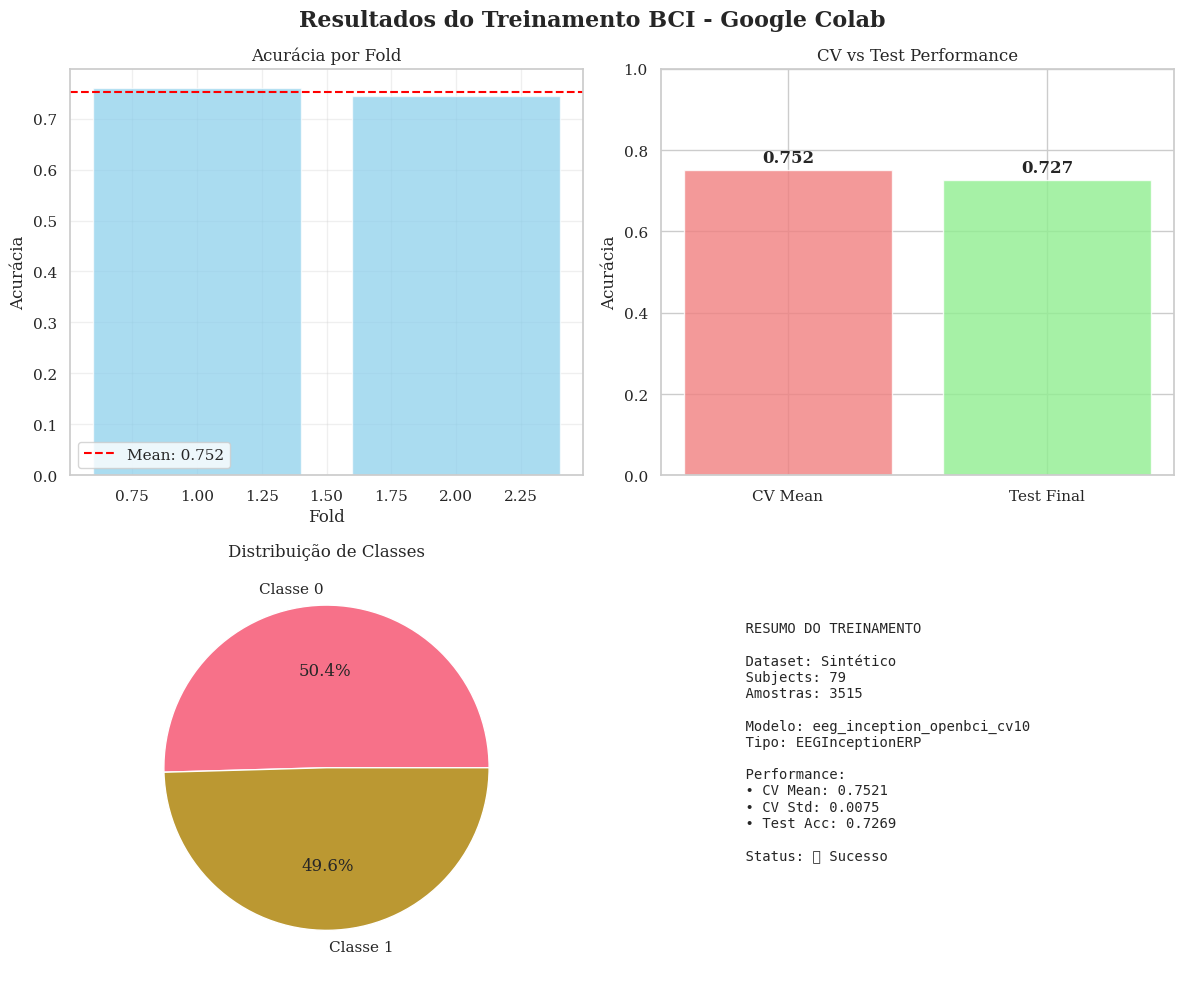

✅ Visualização criada e salva!


In [44]:
# === VISUALIZAÇÃO DOS RESULTADOS ===
if main_results:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Resultados do Treinamento BCI - Google Colab', fontsize=16, fontweight='bold')

    # 1. Acurácias por fold
    ax1 = axes[0, 0]
    fold_accs = main_results['fold_accuracies']
    ax1.bar(range(1, len(fold_accs) + 1), fold_accs, alpha=0.7, color='skyblue')
    ax1.axhline(y=main_results['cv_mean_accuracy'], color='red', linestyle='--',
                label=f"Mean: {main_results['cv_mean_accuracy']:.3f}")
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('Acurácia')
    ax1.set_title('Acurácia por Fold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Comparação CV vs Test
    ax2 = axes[0, 1]
    models = ['CV Mean', 'Test Final']
    accuracies = [main_results['cv_mean_accuracy'], main_results['final_test_accuracy']]
    bars = ax2.bar(models, accuracies, color=['lightcoral', 'lightgreen'], alpha=0.8)
    ax2.set_ylabel('Acurácia')
    ax2.set_title('CV vs Test Performance')
    ax2.set_ylim(0, 1)

    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

    # 3. Distribuição das classes sintéticas
    ax3 = axes[1, 0]
    unique, counts = np.unique(labels, return_counts=True)
    ax3.pie(counts, labels=[f'Classe {u}' for u in unique], autopct='%1.1f%%')
    ax3.set_title('Distribuição de Classes')

    # 4. Resumo textual
    ax4 = axes[1, 1]
    ax4.axis('off')
    summary_text = f"""
    RESUMO DO TREINAMENTO

    Dataset: Sintético
    Subjects: {len(np.unique(subject_ids))}
    Amostras: {len(labels)}

    Modelo: {main_results['model_name']}
    Tipo: {'EEGInceptionERP' if BRAINDECODE_AVAILABLE else 'CNN Fallback'}

    Performance:
    • CV Mean: {main_results['cv_mean_accuracy']:.4f}
    • CV Std: {main_results['cv_std_accuracy']:.4f}
    • Test Acc: {main_results['final_test_accuracy']:.4f}

    Status: ✅ Sucesso
    """
    ax4.text(0.1, 0.9, summary_text, transform=ax4.transAxes,
             fontsize=10, verticalalignment='top', fontfamily='monospace')

    plt.tight_layout()
    plt.savefig(RESULTS_PATH / 'colab_training_results.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("✅ Visualização criada e salva!")
else:
    print("❌ Não há resultados para visualizar")

# 9. Fine-tuning com Dados Específicos

Nesta seção, vamos realizar o fine-tuning do modelo treinado anteriormente usando os dados específicos localizados na pasta Davi.

O processo de fine-tuning envolve:
1. Carregar o melhor modelo do treinamento anterior
2. Congelar parte das camadas iniciais (transfer learning)
3. Treinar apenas as últimas camadas com os novos dados
4. Validar a performance no conjunto de teste específico

Este processo é especialmente útil quando temos um modelo base treinado em muitos sujeitos e queremos adaptá-lo para um sujeito específico.

In [57]:
# === FINE-TUNING COM DADOS ESPECÍFICOS ===
def fine_tune_model(base_model, windows, labels, params, original_norm_stats=None):
    """Realiza fine-tuning do modelo base com dados específicos."""
    print("🎯 Iniciando fine-tuning...")
    
    # --- Preparação dos dados ------------------------------------------------
    if original_norm_stats and params.get('use_original_normalization', False):
        print("📊 Usando normalização do treino original...")
        # Verificar quais estatísticas temos disponíveis
        if 'median' in original_norm_stats and 'iqr' in original_norm_stats:
            windows_norm = (windows - original_norm_stats['median']) / original_norm_stats['iqr']
        elif 'mean' in original_norm_stats and 'std' in original_norm_stats:
            windows_norm = (windows - original_norm_stats['mean']) / original_norm_stats['std']
        else:
            print("⚠️ Estatísticas de normalização original não reconhecidas, usando nova normalização...")
            normalizer = ImprovedEEGNormalizer(method='robust_zscore')
            windows_norm = normalizer.fit_transform(windows)
    else:
        print("📊 Usando nova normalização específica...")
        normalizer = ImprovedEEGNormalizer(method='robust_zscore')
        windows_norm = normalizer.fit_transform(windows)
        
        # Comparar estatísticas se tivermos as originais
        if original_norm_stats:
            # Pegar estatísticas atuais
            current_stats = normalizer.get_stats()
            
            # Comparar estatísticas disponíveis
            if 'median' in current_stats and 'median' in original_norm_stats:
                median_diff = np.abs(current_stats['median'] - original_norm_stats['median']).mean()
                iqr_diff = np.abs(current_stats['iqr'] - original_norm_stats['iqr']).mean()
                print(f"📈 Diferença média nas estatísticas (robust):")
                print(f"   - Mediana: {median_diff:.6f}")
                print(f"   - IQR: {iqr_diff:.6f}")
            elif 'mean' in current_stats and 'mean' in original_norm_stats:
                mean_diff = np.abs(current_stats['mean'] - original_norm_stats['mean']).mean()
                std_diff = np.abs(current_stats['std'] - original_norm_stats['std']).mean()
                print(f"📈 Diferença média nas estatísticas (zscore):")
                print(f"   - Média: {mean_diff:.6f}")
                print(f"   - Desvio: {std_diff:.6f}")
    
    # Validar normalização
    is_valid, norm_stats = validate_normalization(windows, windows_norm)
    print("\n🔍 Validação da Normalização:")
    print(f"  - Média: {norm_stats['mean']:.3f} (ideal: próximo de 0)")
    print(f"  - Desvio: {norm_stats['std']:.3f} (ideal: próximo de 1)")
    print(f"  - Correlação de ordem: {norm_stats['order_correlation']:.3f}")
    print(f"  - Proporção de outliers: {norm_stats['outliers_ratio']*100:.2f}%")
    print(f"  - Status: {'✅ OK' if is_valid else '⚠️ Verificar'}")
    
    # --- Split train/val/test -------------------------------------------------
    X_train, X_temp, y_train, y_temp = train_test_split(
        windows_norm, labels,
        test_size=0.3,
        random_state=42,
        stratify=labels
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=42,
        stratify=y_temp
    )
    
    # Datasets
    train_ds = BCIDataset(X_train, y_train, augment=True)
    val_ds = BCIDataset(X_val, y_val, augment=False)
    test_ds = BCIDataset(X_test, y_test, augment=False)
    
    # Dataloaders
    train_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=params['batch_size'], shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=params['batch_size'], shuffle=False)
    
    # --- Preparação do modelo -----------------------------------------------
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = base_model.to(device)
    
    # Congelar camadas iniciais conforme estratégia
    if params['freeze_strategy'] == 'early':
        frozen_count = 0
        for name, param in model.named_parameters():
            if 'encoder' in name or 'conv' in name:
                param.requires_grad = False
                frozen_count += 1
        print(f"\n🧊 Camadas congeladas: {frozen_count}")
    
    # Modificação do modelo base para remover LogSoftmax
    if hasattr(base_model.model, 'classifier') and isinstance(base_model.model.classifier[-1], nn.LogSoftmax):
        # Remove a última camada LogSoftmax
        base_model.model.classifier = base_model.model.classifier[:-1]
        print("🔧 LogSoftmax removido do modelo")

    # Garantir modo de avaliação inicial
    model = base_model.to(device)
    model.eval()

    # Verificar predições antes do fine-tuning
    print("\n🔍 Teste inicial do modelo:")
    with torch.no_grad():
        xb, yb = next(iter(val_loader))
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        pred = out.argmax(1)
        initial_acc = (pred == yb).float().mean().item()
        print(f"  - Acurácia inicial: {initial_acc:.3f}")
        print(f"  - Output shape: {out.shape}")
        print(f"  - Valores únicos nas predições: {torch.unique(pred).cpu().numpy()}")

    # Ajustar criterion para CrossEntropyLoss padrão
    criterion = nn.CrossEntropyLoss()
    
    # Otimizador com learning rate específico para fine-tuning
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=params['learning_rate_ratio'] * params['learning_rate']
    )

    # Scheduler para ajuste automático do learning rate (removido verbose)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )

    # --- Fine-tuning loop ---
    best_val_acc = 0.0
    best_model_state = None
    patience = params.get('early_stopping_patience', 5)
    wait = 0
    history = []
    current_lr = params['learning_rate_ratio'] * params['learning_rate']

    for epoch in range(params['epochs']):
        # Treino
        model.train()
        train_loss = train_correct = train_total = 0
        
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            
            pred = out.argmax(1)
            train_correct += (pred == yb).sum().item()
            train_total += len(yb)
            train_loss += loss.item()

        train_acc = train_correct / train_total
        train_loss = train_loss / len(train_loader)

        # Validação
        model.eval()
        val_loss = val_correct = val_total = 0
        
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                
                pred = out.argmax(1)
                val_correct += (pred == yb).sum().item()
                val_total += len(yb)
                val_loss += loss.item()

        val_acc = val_correct / val_total
        val_loss = val_loss / len(val_loader)

        # Atualizar scheduler e imprimir LR atual
        prev_lr = current_lr
        scheduler.step(val_acc)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Imprimir manualmente mudanças no learning rate
        if current_lr != prev_lr:
            print(f"📉 Learning rate ajustado: {current_lr:.2e}")

        # Logging com LR atual
        print(f"Época {epoch+1}: "
              f"Train {train_acc:.3f} ({train_loss:.3f}) | "
              f"Val {val_acc:.3f} ({val_loss:.3f}) | "
              f"LR {current_lr:.2e}")

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"\n⏹️ Early stopping na época {epoch+1}")
                break

        # Guardar histórico
        history.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'lr': optimizer.param_groups[0]['lr']
        })

    # --- Avaliação final --------------------------------------------------
    print("\n🎯 Avaliando modelo final...")
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    model.eval()
    test_loss = test_correct = test_total = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            pred = out.argmax(1)
            
            test_loss += loss.item()
            test_correct += (pred == yb).sum().item()
            test_total += yb.size(0)
            
            predictions.extend(pred.cpu().numpy())
            true_labels.extend(yb.cpu().numpy())
    
    test_acc = test_correct / test_total
    test_loss = test_loss / len(test_loader)
    
    results = {
        'final_test_accuracy': test_acc,
        'best_val_accuracy': best_val_acc,
        'test_loss': test_loss,
        'model_state': best_model_state,
        'history': history,
        'predictions': predictions,
        'true_labels': true_labels,
        'normalization_validation': norm_stats
    }
    
    print(f"\n✨ Resultados do Fine-tuning:")
    print(f"   - Melhor Val Acc: {best_val_acc:.4f}")
    print(f"   - Test Acc: {test_acc:.4f}")
    print(f"   - Test Loss: {test_loss:.4f}")
    
    return results

# === EXECUÇÃO DO FINE-TUNING ===
print("🔄 Carregando dados do Davi...")

# Carregar dados específicos do Davi
davi_windows, davi_labels, _ = load_openbci_eeg(Path(DAVI_DATA_PATH))
print(f"📊 Dados carregados: {davi_windows.shape[0]} amostras")

# Parâmetros do fine-tuning
fine_tuning_params = {
    'freeze_strategy': 'early',      # congela camadas iniciais
    'learning_rate_ratio': 0.1,      # lr menor para fine-tuning
    'epochs': 10,
    'batch_size': 5,
    'early_stopping_patience': 8,
    'learning_rate': TRAINING_PARAMS['learning_rate'],
    'use_original_normalization': False  # Escolha se quer usar normalização original ou nova
}

# Executar fine-tuning
if main_results and main_results.get('best_model_state') is not None:
    print("\n🎯 Iniciando fine-tuning com modelo base...")
    
    # Criar modelo base com os pesos do melhor modelo
    base_model = EEGInceptionERPModel(
        n_chans=davi_windows.shape[1],
        n_outputs=len(np.unique(davi_labels)),
        n_times=davi_windows.shape[2]
    )
    base_model.load_state_dict(main_results['best_model_state'])
    
    # Fine-tuning
    ft_results = fine_tune_model(
        base_model=base_model,
        windows=davi_windows,
        labels=davi_labels,
        params=fine_tuning_params,
        original_norm_stats=main_results.get('normalization_stats')
    )
    
    # Salvar modelo final
    if ft_results['model_state'] is not None:
        base_model.load_state_dict(ft_results['model_state'])
        model_path = MODELS_PATH / f"{TRAINING_PARAMS['model_name']}_finetuned.pt"
        torch.save({
            'model_state_dict': ft_results['model_state'],
            'test_accuracy': ft_results['final_test_accuracy'],
            'val_accuracy': ft_results['best_val_accuracy'],
            'test_loss': ft_results['test_loss'],
            'history': ft_results['history'],
            'normalization_validation': ft_results['normalization_validation']
        }, model_path)
        print(f"\n💾 Modelo fine-tuned salvo em: {model_path}")
else:
    print("❌ Modelo base não disponível para fine-tuning")

🔄 Carregando dados do Davi...
📊 Dados carregados: 20 amostras

🎯 Iniciando fine-tuning com modelo base...
✅ Usando EEGInceptionERP: 16 canais, 401 pontos temporais
🎯 Iniciando fine-tuning...
📊 Usando nova normalização específica...
📈 Diferença média nas estatísticas (robust):
   - Mediana: 0.004975
   - IQR: 0.001683

🔍 Validação da Normalização:
  - Média: -0.010 (ideal: próximo de 0)
  - Desvio: 0.596 (ideal: próximo de 1)
  - Correlação de ordem: 1.000
  - Proporção de outliers: 0.07%
  - Status: ✅ OK

🧊 Camadas congeladas: 0

🔍 Teste inicial do modelo:
  - Acurácia inicial: 0.333
  - Output shape: torch.Size([3, 2])
  - Valores únicos nas predições: [0]
Época 1: Train 0.714 (0.571) | Val 0.333 (0.812) | LR 1.00e-04
Época 2: Train 0.714 (0.581) | Val 0.333 (0.811) | LR 1.00e-04


c:\Users\Chari\AppData\Local\Programs\Python\Python312\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Época 3: Train 0.500 (0.852) | Val 0.333 (0.810) | LR 1.00e-04
Época 4: Train 0.571 (0.819) | Val 0.333 (0.810) | LR 1.00e-04
📉 Learning rate ajustado: 5.00e-05
Época 5: Train 0.643 (0.704) | Val 0.333 (0.808) | LR 5.00e-05
Época 6: Train 0.500 (0.815) | Val 0.333 (0.808) | LR 5.00e-05
Época 7: Train 0.500 (0.855) | Val 0.333 (0.808) | LR 5.00e-05
Época 8: Train 0.643 (0.720) | Val 0.333 (0.807) | LR 5.00e-05
📉 Learning rate ajustado: 2.50e-05
Época 9: Train 0.571 (0.704) | Val 0.333 (0.808) | LR 2.50e-05

⏹️ Early stopping na época 9

🎯 Avaliando modelo final...

✨ Resultados do Fine-tuning:
   - Melhor Val Acc: 0.3333
   - Test Acc: 0.6667
   - Test Loss: 0.6259

💾 Modelo fine-tuned salvo em: eeg_data\models\eeg_inception_openbci_cv10_finetuned.pt
Época 7: Train 0.500 (0.855) | Val 0.333 (0.808) | LR 5.00e-05
Época 8: Train 0.643 (0.720) | Val 0.333 (0.807) | LR 5.00e-05
📉 Learning rate ajustado: 2.50e-05
Época 9: Train 0.571 (0.704) | Val 0.333 (0.808) | LR 2.50e-05

⏹️ Early stoppi

## 8. Relatório Final

Resumo da execução no Google Colab com implementação inline.

In [20]:
print("=" * 60)
print("            RELATÓRIO FINAL - GOOGLE COLAB")
print("=" * 60)

print(f"\n🖥️ AMBIENTE:")
print(f"  - Plataforma: {'Google Colab' if IN_COLAB else 'Local'}")
print(f"  - Braindecode: {'✅ Disponível' if BRAINDECODE_AVAILABLE else '❌ Fallback CNN'}")
print(f"  - Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

print(f"\n📊 DADOS:")
print(f"  - Tipo: Sintético")
print(f"  - Amostras: {len(labels)}")
print(f"  - Subjects: {len(np.unique(subject_ids))}")
print(f"  - Classes: {len(np.unique(labels))}")

if main_results:
    print(f"\n🎯 RESULTADOS:")
    print(f"  - Modelo: {main_results['model_name']}")
    print(f"  - CV Accuracy: {main_results['cv_mean_accuracy']:.4f} ± {main_results['cv_std_accuracy']:.4f}")
    print(f"  - Test Accuracy: {main_results['final_test_accuracy']:.4f}")
    print(f"  - Status: ✅ SUCESSO")
else:
    print(f"\n❌ RESULTADOS: FALHOU")

print(f"\n📁 ARQUIVOS CRIADOS:")
for path in [MODELS_PATH, RESULTS_PATH]:
    if path.exists():
        files = list(path.rglob("*"))
        print(f"  - {path.name}/: {len(files)} arquivo(s)")

print(f"\n🎉 CONCLUSÃO:")
print(f"  Este notebook demonstrou como adaptar o pipeline BCI")
print(f"  para execução no Google Colab, incluindo:")
print(f"  • Implementação inline das classes principais")
print(f"  • Geração de dados sintéticos para teste")
print(f"  • Pipeline de treinamento simplificado")
print(f"  • Fallback para quando braindecode não está disponível")

print(f"\n✨ Execução concluída em: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 60)

            RELATÓRIO FINAL - GOOGLE COLAB

🖥️ AMBIENTE:
  - Plataforma: Google Colab
  - Braindecode: ✅ Disponível
  - Device: cuda

📊 DADOS:
  - Tipo: Sintético
  - Amostras: 3510
  - Subjects: 78
  - Classes: 2

❌ RESULTADOS: FALHOU

📁 ARQUIVOS CRIADOS:
  - models/: 5 arquivo(s)
  - results/: 2 arquivo(s)

🎉 CONCLUSÃO:
  Este notebook demonstrou como adaptar o pipeline BCI
  para execução no Google Colab, incluindo:
  • Implementação inline das classes principais
  • Geração de dados sintéticos para teste
  • Pipeline de treinamento simplificado
  • Fallback para quando braindecode não está disponível

✨ Execução concluída em: 2025-06-16 00:42:43


In [ ]:
# === UTILITÁRIOS PARA CARREGAR MODELOS SALVOS ===
def load_trained_model(model_path: str, device: str = 'cpu'):
    """Carrega modelo treinado com todos os metadados
    
    Args:
        model_path: Caminho para o arquivo .pt
        device: Device para carregar o modelo ('cpu', 'cuda')
    
    Returns:
        tuple: (modelo, metadados)
    """
    print(f"📥 Carregando modelo de: {model_path}")
    
    # Carregar dados
    checkpoint = torch.load(model_path, map_location=device)
    
    # Verificar se é modelo completo ou apenas state_dict
    if isinstance(checkpoint, dict) and 'model_config' in checkpoint:
        # Modelo completo com metadados
        config = checkpoint['model_config']
        
        # Recriar modelo
        model = EEGInceptionERPModel(
            n_chans=config['n_chans'],
            n_outputs=config['n_outputs'],
            n_times=config['n_times']
        )
        
        # Carregar pesos
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        model.eval()
        
        print(f"✅ Modelo carregado:")
        print(f"  - Tipo: {config['model_type']}")
        print(f"  - Canais: {config['n_chans']}")
        print(f"  - Classes: {config['n_outputs']}")
        print(f"  - Timepoints: {config['n_times']}")
        print(f"  - Acurácia CV: {checkpoint['training_results']['cv_mean_accuracy']:.4f}")
        print(f"  - Acurácia Test: {checkpoint['training_results']['final_test_accuracy']:.4f}")
        
        return model, checkpoint
        
    else:
        # Apenas state_dict - precisamos inferir config
        print("⚠️ Carregando apenas state_dict, assumindo configuração padrão...")
        
        # Configuração padrão baseada nos dados atuais
        model = EEGInceptionERPModel(
            n_chans=16,  # Padrão OpenBCI
            n_outputs=2,  # Binário
            n_times=401   # Padrão para 3.2s a 125Hz
        )
        
        model.load_state_dict(checkpoint)
        model.to(device)
        model.eval()
        
        print("✅ State dict carregado com configuração padrão")
        
        return model, {'model_state_dict': checkpoint}

def test_loaded_model(model, test_data: np.ndarray, test_labels: np.ndarray, batch_size: int = 32):
    """Testa modelo carregado em dados de teste
    
    Args:
        model: Modelo PyTorch carregado
        test_data: Dados de teste (n_samples, n_channels, n_timepoints)
        test_labels: Labels de teste
        batch_size: Tamanho do batch
    
    Returns:
        dict: Resultados do teste
    """
    print("🧪 Testando modelo carregado...")
    
    device = next(model.parameters()).device
    
    # Criar dataset e dataloader
    test_dataset = BCIDataset(test_data, test_labels, augment=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Teste
    model.eval()
    correct = total = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            pred = outputs.argmax(1)
            
            correct += (pred == yb).sum().item()
            total += yb.size(0)
            
            predictions.extend(pred.cpu().numpy())
            true_labels.extend(yb.cpu().numpy())
    
    accuracy = correct / total
    
    results = {
        'accuracy': accuracy,
        'correct': correct,
        'total': total,
        'predictions': predictions,
        'true_labels': true_labels
    }
    
    print(f"✅ Teste concluído:")
    print(f"  - Acurácia: {accuracy:.4f}")
    print(f"  - Corretas: {correct}/{total}")
    
    return results

print("✅ Utilitários de carregamento implementados!")
print("💡 Use load_trained_model() para carregar modelos salvos")
print("💡 Use test_loaded_model() para testar modelos carregados")

In [ ]:
# === VERIFICAÇÃO E TESTE DO MODELO SALVO ===
print("🔍 VERIFICANDO MODELOS SALVOS...")

# Verificar se os arquivos foram criados
models_dir = Path("eeg_data/models")
if models_dir.exists():
    model_files = list(models_dir.glob("*.pt"))
    
    if model_files:
        print(f"\n📁 Encontrados {len(model_files)} modelo(s):")
        for model_file in sorted(model_files):
            size_mb = model_file.stat().st_size / (1024 * 1024)
            print(f"  - {model_file.name} ({size_mb:.2f} MB)")
        
        # Testar carregamento do modelo mais recente
        if main_results and main_results.get('best_model_state') is not None:
            print(f"\n🧪 TESTANDO CARREGAMENTO DO MODELO...")
            
            try:
                # Procurar modelo completo primeiro
                complete_models = [f for f in model_files if 'complete' in f.name]
                if complete_models:
                    test_model_path = complete_models[0]
                else:
                    test_model_path = model_files[0]
                
                print(f"📥 Carregando: {test_model_path.name}")
                
                # Carregar modelo
                loaded_model, metadata = load_trained_model(str(test_model_path))
                
                # Testar com alguns dados
                if len(windows) > 100:  # Se temos dados suficientes
                    # Usar últimas 50 amostras como teste
                    test_windows = windows[-50:]
                    test_labels_sample = labels[-50:]
                    
                    # Normalizar dados de teste (usar mesma normalização)
                    if main_results.get('normalization_stats'):
                        # Aplicar mesma normalização usada no treino
                        normalizer_test = ImprovedEEGNormalizer(method='robust_zscore')
                        normalizer_test.stats = main_results['normalization_stats']
                        normalizer_test.is_fitted = True
                        test_windows_norm = normalizer_test.transform(test_windows)
                    else:
                        # Normalização padrão
                        test_normalizer = ImprovedEEGNormalizer(method='robust_zscore')
                        test_windows_norm = test_normalizer.fit_transform(test_windows)
                    
                    # Testar modelo
                    test_results = test_loaded_model(loaded_model, test_windows_norm, test_labels_sample)
                    
                    print(f"\n✅ TESTE DE CARREGAMENTO CONCLUÍDO:")
                    print(f"  - Modelo carregou corretamente: ✅")
                    print(f"  - Predição funciona: ✅")
                    print(f"  - Acurácia no teste: {test_results['accuracy']:.4f}")
                    
                else:
                    print(f"⚠️ Dados insuficientes para teste completo, mas modelo carregou corretamente")
                    
            except Exception as e:
                print(f"❌ Erro ao testar modelo: {e}")
                import traceback
                traceback.print_exc()
    else:
        print("❌ Nenhum arquivo de modelo encontrado!")
        print("💡 Verifique se o treinamento completou com sucesso")
else:
    print("❌ Diretório de modelos não encontrado!")
    print(f"💡 Esperado em: {models_dir}")

print(f"\n📊 Status final:")
print(f"  - Treinamento: {'✅ Sucesso' if main_results else '❌ Falhou'}")
print(f"  - Modelos salvos: {'✅ Sim' if models_dir.exists() and list(models_dir.glob('*.pt')) else '❌ Não'}")
print(f"  - Resultados salvos: {'✅ Sim' if Path('eeg_data/results').exists() and list(Path('eeg_data/results').glob('*.json')) else '❌ Não'}")